In [1]:
from Utils import create_dist3_task, Logging
from Models.ESBN_reimplementation import Dist3ESBN, Dist3Transformer
import tensorflow as tf
from PIL import Image
import datetime
import tensorboard
%load_ext tensorboard
%rm -rf ./logs/reimplementation/
tf.config.run_functions_eagerly(False)

In this notebook, we recreate the distribution-of-three experiment by (Webb 2023) using the ESBN. We will recreate the m=0 and the m=95 condition. 
Afterwards, we will see whether the key size can be reduced while retaining performance.
Task creation is similar to (Webb 2023).

In [2]:
# Experimental condition: m = 0
m_holdout = 0

# Set train parameters
batch_size = 32
train_set_size = 10000
train_proportion = 0.95

# Set test parameters
test_batch_size = 32
test_set_size = 10000


# Generate training and test sets
train_data, test_data = create_dist3_task.create_task(train_set_size, test_set_size, train_proportion, m_holdout, n_shapes=10)

2024-04-01 15:08:31.253515: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


tf.Tensor(3, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(3, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)


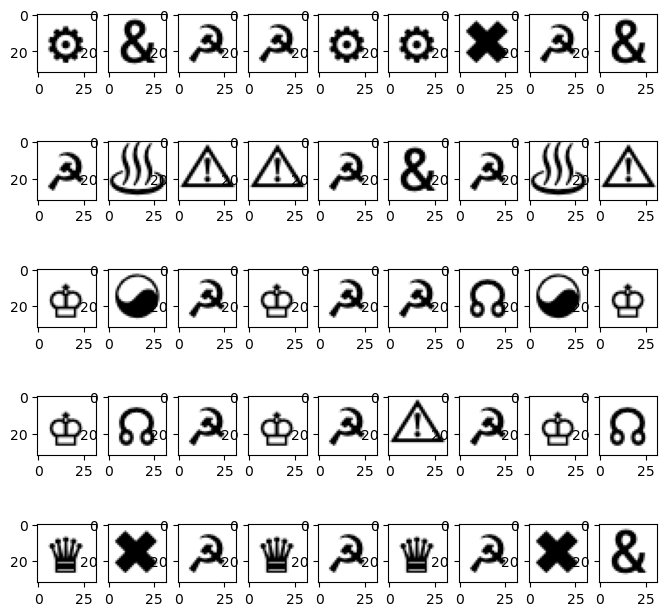

In [3]:
# Show samples of train and test data
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 8))
columns = 9
rows = 5
i = 0
for (sequence, label) in train_data.take(5):
    for j in range(len(sequence[0])):
        img = sequence[0, j]
        fig.add_subplot(rows, columns, 9*i+j+1)
        plt.imshow(img, cmap='gray')
    print(label[0])
    i += 1
plt.show()

In [4]:
# Re-run m=0 condition
z_size = 128
key_size = 256
hidden_size = 512

log_dir = "logs/reimplementation/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "_m0"
model = Logging.BatchLoggingModel(Dist3ESBN(z_size, key_size, hidden_size), log_dir)
model.compile(optimizer="Adam",
               loss="sparse_categorical_crossentropy",
               metrics=["accuracy"])

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model.fit(train_data, 
          epochs=10,
          validation_data=test_data,
          callbacks=[tensorboard_callback])

Epoch 1/10
  1/128 [..............................] - ETA: 5:00 - loss: 1.3859 - accuracy: 0.2812

KeyboardInterrupt: 

In [ ]:
# Experimental condition: m = 95
m_holdout = 0

# Set train parameters
batch_size = 32
train_set_size = 10000
train_proportion = 0.95

# Set test parameters
test_batch_size = 32
test_set_size = 10000


# Generate training and test sets
train_data, test_data = create_dist3_task.create_task(train_set_size, test_set_size, train_proportion, m_holdout)

In [ ]:
# Show samples of train and test data
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 8))
columns = 9
rows = 5
i = 0
for (sequence, label) in train_data.take(5):
    for j in range(len(sequence[0])):
        img = sequence[0, j]
        fig.add_subplot(rows, columns, 9*i+j+1)
        plt.imshow(img, cmap='gray')
    print(label[0])
    i += 1
plt.show()

In [ ]:
z_size = 128
key_size = 256
hidden_size = 512

log_dir = "logs/reimplementation/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "_m95"
model = Logging.BatchLoggingModel(Dist3ESBN(z_size, key_size, hidden_size), log_dir)
model.compile(optimizer="Adam",
               loss="sparse_categorical_crossentropy",
               metrics=["accuracy"])

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model.fit(train_data, 
          epochs=10,
          validation_data=test_data,
          callbacks=[tensorboard_callback])

In [3]:
tf.config.run_functions_eagerly(False)
log_dir = "logs/reimplementation/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "_m95_transformer"
model = Logging.BatchLoggingModel(Dist3Transformer(), log_dir)
model.compile(optimizer="Adam",
               loss="sparse_categorical_crossentropy",
               metrics=["accuracy"])

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model.fit(train_data, 
          epochs=10,
          validation_data=test_data,
          callbacks=[tensorboard_callback])

Epoch 1/10


2024-04-01 15:10:20.802681: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


[[0.216537416 0.342344135 0.268542469 0.17257601]
 [0.339317054 0.279193938 0.225212708 0.156276271]
 [0.340425044 0.274988741 0.246532455 0.138053834]
 ...
 [0.283914894 0.316223174 0.235712066 0.16414994]
 [0.278499454 0.331928849 0.231763065 0.157808647]
 [0.351038963 0.299247712 0.217095882 0.132617489]]
  1/128 [..............................] - ETA: 3:50 - loss: 1.3443 - accuracy: 0.3750[[0.0576187596 0.22526148 0.283351392 0.433768451]
 [0.0977049768 0.275130898 0.284232378 0.342931777]
 [0.0652901 0.162370488 0.255771667 0.516567767]
 ...
 [0.064983286 0.165156871 0.254319847 0.515539944]
 [0.0932788923 0.191195175 0.281133085 0.434392899]
 [0.0674485937 0.19998011 0.335439742 0.397131592]]
[[0.0419494 0.0672640651 0.593768775 0.297017783]
 [0.0225645639 0.054607287 0.652964056 0.269864082]
 [0.0187258851 0.0492063798 0.416221768 0.515845895]
 ...
 [0.0317331403 0.05818744 0.549797297 0.360282093]
 [0.0424007289 0.0488192327 0.681101 0.227678984]
 [0.0670614243 0.0762674138 0.5

KeyboardInterrupt: 